## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import pickle
import os
import time

from random import shuffle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

## Helper Function

In [3]:
def show_images(imgs, titles=None, ncols=2):
    n = len(imgs)
    nrows = (n + ncols - 1) // ncols
    
    f, ax = plt.subplots(nrows, 2, figsize=(10, 10 * nrows))
    f.tight_layout()

    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        if i < n:
            img = imgs[i]
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if titles != None:
                ax.set_title(titles[i], fontsize=15)        
        ax.axis('off')
        
def show_image(img, title=''):
    show_images([img], [title], 1)

def save_image(prefix, basename, img):
    fname = "output_images/{}_{}".format(prefix, basename)
    mpimg.imsave(fname, img)

## 1. Data preparation

In [4]:
# load images of car and non-car
img_cars = [mpimg.imread(fname) for fname in glob.glob("data/vehicles/*/*.*")]
img_nocars = [mpimg.imread(fname) for fname in glob.glob("data/non-vehicles/*/*.*")]

# shuffle them
shuffle(img_cars)
shuffle(img_nocars)

im = img_cars[0]
print("# of vehicles images: {}".format(len(img_cars)))
print("# of non-vehicles images: {}".format(len(img_nocars)))
print("image shape {} of type {}".format(im.shape, im.dtype))


# of vehicles images: 8792
# of non-vehicles images: 8968
image shape (64, 64, 3) of type float32


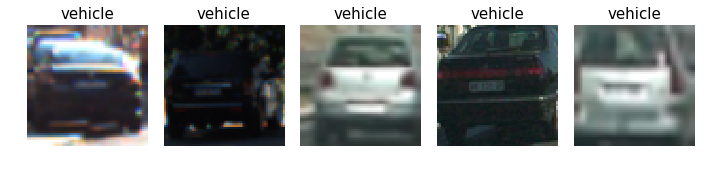

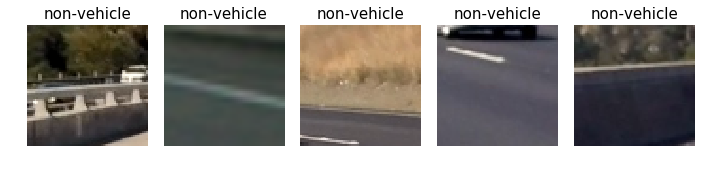

In [5]:
# display some exmaples
N = 5

# vehicles
show_images(img_cars[:N], ['vehicle'] * N, ncols=N)

# non-vehicles 
show_images(img_nocars[:N], ['non-vehicle'] * N, ncols=N)

## 2. HOG features

In [6]:
# hog function
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # two outputs (features, hog_image) if vis==True
    # otherwise with one output (features)
    return hog(img, orientations=orient, 
              pixels_per_cell=(pix_per_cell, pix_per_cell),
              cells_per_block=(cell_per_block, cell_per_block), 
              transform_sqrt=False, block_norm='L2-Hys',
              visualise=vis, feature_vector=feature_vec)

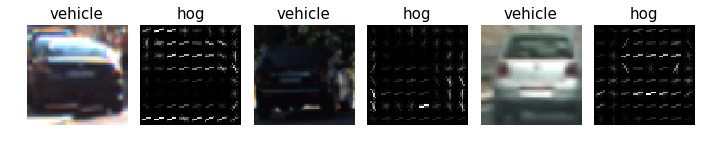

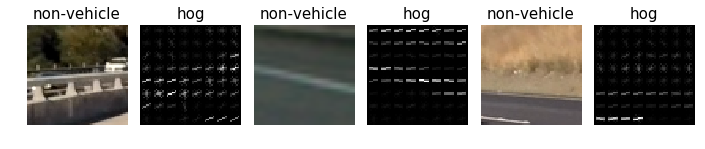

In [7]:
# draw hog of examples
orient = 9
pix_per_cell = 8
cell_per_block = 2

def show_hogs(imgs, label):   
    results = []
    labels = []
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = get_hog_features(gray, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        results += [img, hog_image]
        labels += [label, 'hog']

    show_images(results, labels, ncols=len(imgs) * 2)
    
show_hogs(img_cars[:3], 'vehicle')
show_hogs(img_nocars[:3], 'non-vehicle')

## 3. Color histogram features

In [8]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    bins_range=(0, 1)
    
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = ch1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

    if vis == True:
        return ch1_hist[0], ch2_hist[0], ch3_hist[0], bin_centers
    else:
        return hist_features

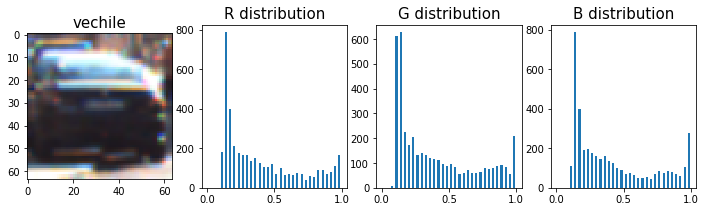

In [9]:
# draw color histgram of an example

# Read in the image
img = img_cars[0]
channelR_hist, channelG_hist, channelB_hist, bin_centers = color_hist(img, vis=True)

# Plot the examples
fig = plt.subplots(1, 4, figsize=(12,3));

def plotHist(id, nplots, center, bars, label):
    plt.subplot(1, nplots, id)
    plt.bar(center, bars, 0.5 / len(center))
    plt.title(label, fontsize=15)

# plot vehicle
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('vechile', fontsize=15)

# plot histograms
plotHist(2, 4, bin_centers, channelR_hist, 'R distribution')
plotHist(3, 4, bin_centers, channelG_hist, 'G distribution')
plotHist(4, 4, bin_centers, channelB_hist, 'B distribution')


## 4. Spatial Binning of Color features

In [10]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel(order='F') 

    # Return the feature vector
    return features

Text(0.5,1,'bin spatial')

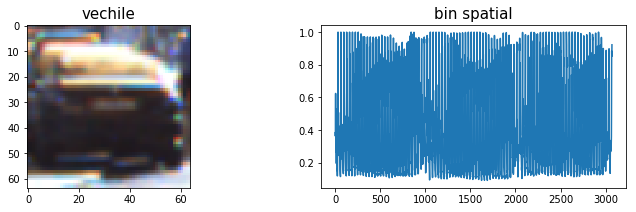

In [11]:
# Read in the image
img = img_cars[0]
spatial_features = bin_spatial(img)

# Plot the examples
fig = plt.subplots(1, 2, figsize=(12,3));

# plot vehicle
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,::-1])
plt.title('vechile', fontsize=15)

# plot bin spatial
plt.subplot(1, 2, 2)
plt.plot(spatial_features)
plt.title('bin spatial', fontsize=15)

## 5. Feature Extractions

In [12]:
# Define a function to extract features from a list of images
def extract_features(images, color_space='HLS', 
                     hist_bins=32, 
                     spatial_size=(32, 32),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in images:
        img_features = []

        # apply color conversion if other than 'BGR'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        # hog features
        hog1 = get_hog_features(feature_image[:,:,0], 
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
        hog2 = get_hog_features(feature_image[:,:,1], 
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
        hog3 = get_hog_features(feature_image[:,:,2], 
                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
        
        # hist color features
        hist_features = color_hist(feature_image, nbins=hist_bins)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        features.append(np.concatenate((hist_features, spatial_features, hog1, hog2, hog3)))

    # Return list of feature vectors
    return features

In [13]:
# test extract_features by examples
features = extract_features(img_cars[:3])
print('feaure length: {}'.format(len(features[0])))

feaure length: 8460


## 6. Training and testing Support Vector Classifier

In [14]:
# get features
feature_cars = extract_features(img_cars)
feature_nocars = extract_features(img_nocars)

In [15]:
# Create an array stack of feature vectors
X = np.vstack((feature_cars, feature_nocars)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(feature_cars)), np.zeros(len(feature_nocars))))

In [16]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=1234)

In [17]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
elapse = time.time() - t
print('SVC took {:.2f} seconds to train {} samples.'.format(elapse, len(y_train)))

SVC took 26.80 seconds to train 14208 samples.


In [18]:
# test accuracy
score = svc.score(X_test, y_test)
print('Test Accuracy: {:.2f}%'.format(score*100))
print('  Predictions: {}'.format(svc.predict(X_test[0:10])))
print('       Labels: {}'.format(y_test[0:10]))

Test Accuracy: 97.49%
  Predictions: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
       Labels: [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]


## 7. Classification using CNN (EXTRA WORKS)
We can use CNN to do classification.  It is easier, faster and more accurate. 

In [19]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D

def create_model():
    '''
        to create nVidia car self-driving model
    '''
    model = Sequential()
    model.add(Lambda(lambda x: x - 0.5, input_shape=(64, 64, 3)))
    model.add(Conv2D(24, (3,3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, (3,3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (3,3), activation='relu'))

    model.add(Flatten())
    model.add(Dense(80, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

cnn = create_model()
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

/home/simon/anaconda3/envs/CarND/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 24)        672       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 36)        7812      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 48)        15600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8112)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                649040    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                810       
__________

In [20]:
# prepase it and train it
sample_X = []
sample_y = []
sample_X += img_cars
sample_y += [1] * len(img_cars)
sample_X += img_nocars
sample_y += [0] * len(img_nocars)

# don't need shuffle samples, train_test_split will shuffle for us
X_train, X_test, y_train, y_test = train_test_split(sample_X, sample_y,
                                                    test_size=0.2,
                                                    random_state=1234)

# data argument: add X_train, y_train by mirror
for x, y in list(zip(X_train, y_train)):
    X_train.append(x[:,::-1,:])   # mirror image
    y_train.append(y)

X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)
print("training set: {}", len(y_train))
print("testing set: {}", len(y_test))

training set: {} 28416
testing set: {} 3552


In [21]:
cnn.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
score = cnn.evaluate(X_test, y_test, batch_size=32)
print('')
print('Test Accuracy by CNN: {:.2f}%'.format(score[1]*100))

Train on 28416 samples, validate on 3552 samples
Epoch 1/5
28416/28416 [==============================] - 10s 347us/step - loss: 0.1216 - acc: 0.9527 - val_loss: 0.0598 - val_acc: 0.9811
Epoch 2/5
28416/28416 [==============================] - 9s 312us/step - loss: 0.0545 - acc: 0.9811 - val_loss: 0.0443 - val_acc: 0.9859
Epoch 3/5
28416/28416 [==============================] - 9s 309us/step - loss: 0.0354 - acc: 0.9874 - val_loss: 0.0369 - val_acc: 0.9862
Epoch 4/5
28416/28416 [==============================] - 9s 310us/step - loss: 0.0315 - acc: 0.9897 - val_loss: 0.0363 - val_acc: 0.9896
Epoch 5/5
3552/3552 [==============================] - 0s 123us/step

Test Accuracy by CNN: 99.24%


## 8. Sliding Window Implementation

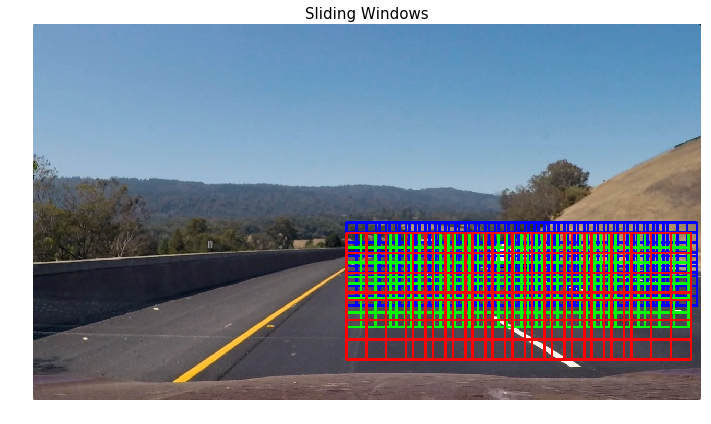

In [22]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img = mpimg.imread('test_images/test3.jpg')

windows =  slide_window(test_img,
                x_start_stop=[600, None],
                y_start_stop=[380, 550], #tune the parameters
                xy_window=(64, 64),
                xy_overlap=(.7,.7))
window_img = draw_boxes(test_img, windows, color=(0,0,255))

windows =  slide_window(test_img,
                x_start_stop=[600, None],
                y_start_stop=[400, 600], #tune the parameters
                xy_window=(96, 96),
                xy_overlap=(.7,.7))
window_img = draw_boxes(window_img, windows, color=(0,255,0))

windows =  slide_window(test_img,
                x_start_stop=[600, None],
                y_start_stop=[400, 656], #tune the parameters
                xy_window=(128, 128),
                xy_overlap=(.7,.7))
window_img = draw_boxes(window_img, windows, color=(255,0,0))

show_image(window_img, 'Sliding Windows')


## 9. Search Cars by Hog

In [23]:
# This function is very similar to extract_features()
# just for a single image rather than list of images
# k
def single_img_features(image):    
    #1) Define an empty list to receive features
    img_features = extract_features([image])
    return img_features[0]

In [24]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_by_hog(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

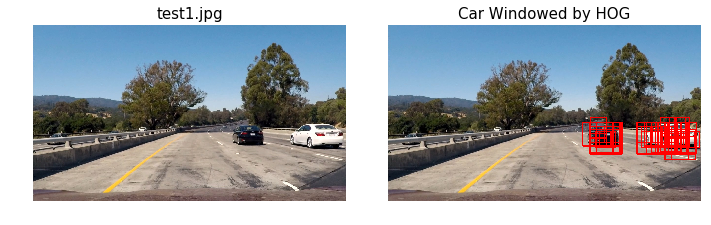

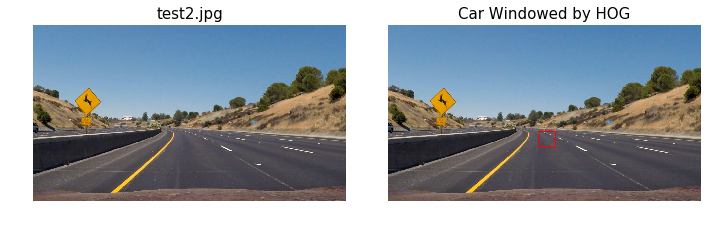

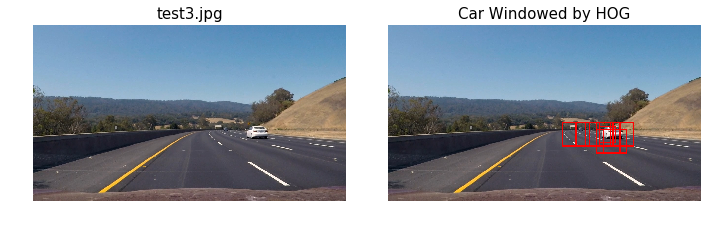

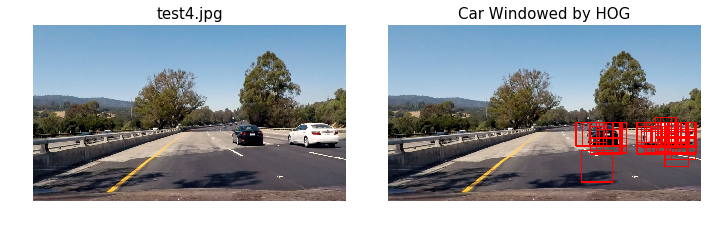

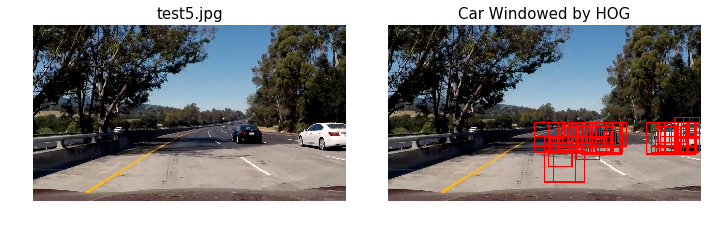

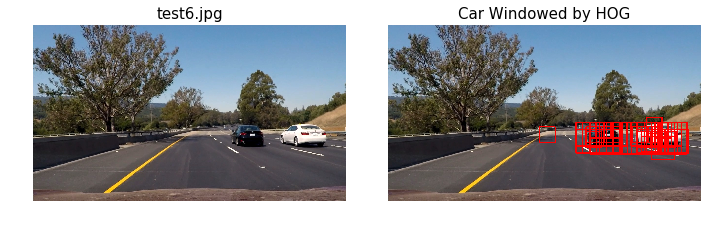

In [25]:
def search_cars(image, search_windows, clf):

    image = image.astype(np.float32) / np.max(image)

    windows = []
    windows +=  slide_window(image,
                    x_start_stop=[600, None],
                    y_start_stop=[380, 550], #tune the parameters
                    xy_window=(64, 64),
                    xy_overlap=(.7,.7))

    windows +=  slide_window(image,
                    x_start_stop=[600, None],
                    y_start_stop=[400, 600], #tune the parameters
                    xy_window=(96, 96),
                    xy_overlap=(.7,.7))

    windows +=  slide_window(image,
                    x_start_stop=[600, None],
                    y_start_stop=[400, 656], #tune the parameters
                    xy_window=(128, 128),
                    xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, clf, X_scaler)    
    return hot_windows
    
testfiles = sorted(glob.glob('test_images/test*.jpg'))
for fname in testfiles:
    img = mpimg.imread(fname)
    hot_windows = search_cars(img, search_by_hog, svc)
    img_boxed = draw_boxes(img, hot_windows) 
    basename = fname.split('/')[-1]
    show_images([img, img_boxed],[basename, 'Car Windowed by HOG'])
    save_image("hog_boxes", basename, img_boxed)

## 10. Search Cars by CNN (Extra Works)

In [26]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_by_cnn(img, windows, clf, dummy):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        test_img = np.expand_dims(test_img, axis=0)
        prediction = clf.predict(test_img)
        if prediction[0][0] > 0.5:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

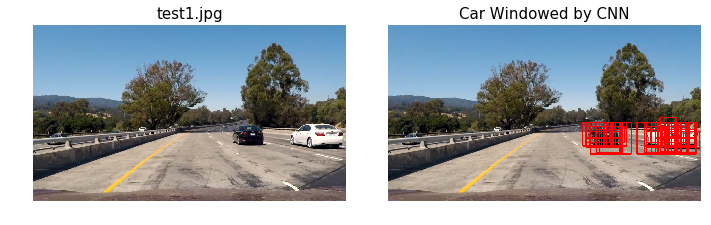

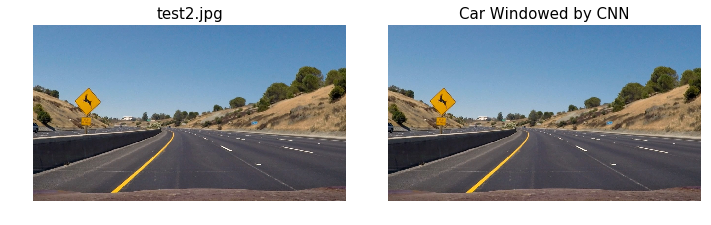

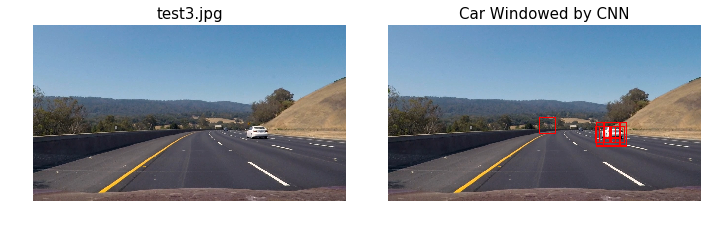

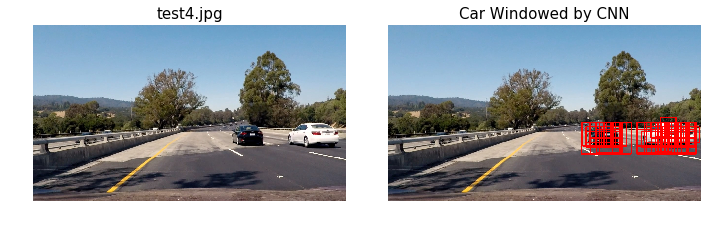

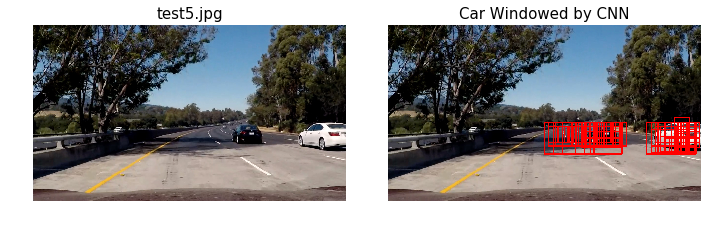

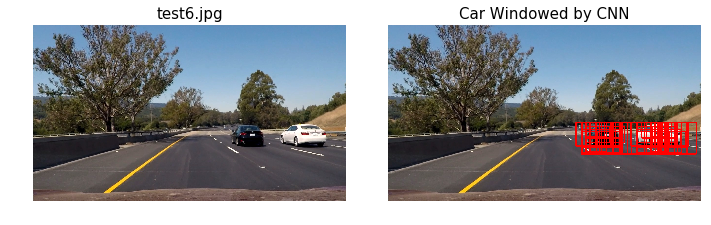

In [27]:
testfiles = sorted(glob.glob('test_images/test*.jpg'))
for fname in testfiles:
    img = mpimg.imread(fname)
    hot_windows = search_cars(img, search_by_cnn, cnn)
    img_boxed = draw_boxes(img, hot_windows) 
    basename = fname.split('/')[-1]
    show_images([img, img_boxed],[basename, 'Car Windowed by CNN'])
    save_image("cnn_boxes", basename, img_boxed)

## 11. HOG with heat map

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img


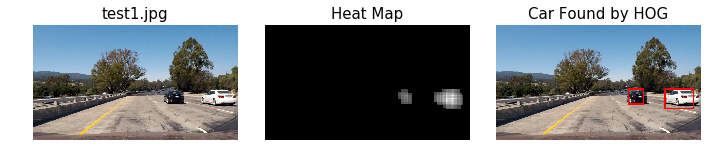

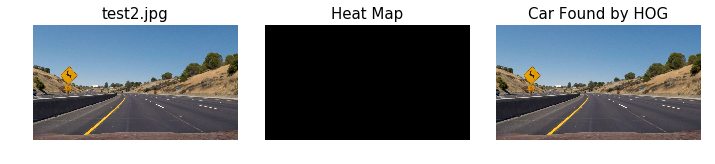

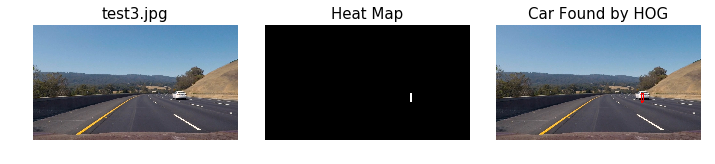

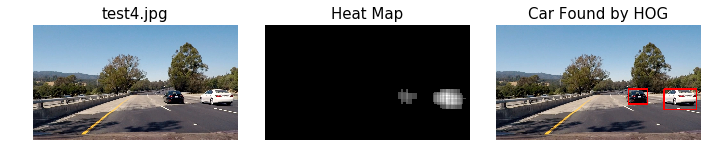

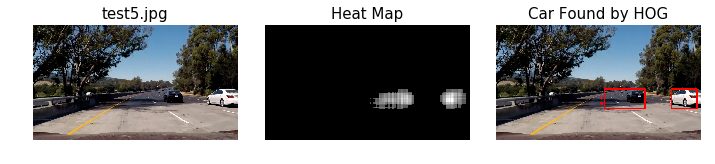

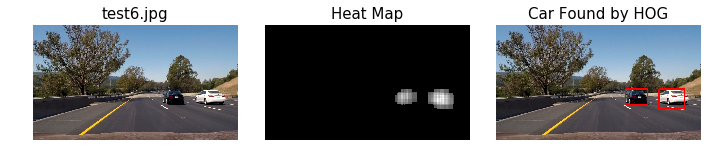

In [29]:
def find_cars(img, search_method, clf, thresh):
    hot_windows = search_cars(img, search_method, clf)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, thresh)  
    labels = label(heat)
    return labels, heat
    
testfiles = sorted(glob.glob('test_images/test*.jpg'))
for fname in testfiles:
    img = mpimg.imread(fname)
    labels, heat = find_cars(img, search_by_hog, svc, thresh=5)
    
    img_boxed = draw_labeled_bboxes(img, labels) 
    basename = fname.split('/')[-1]
    show_images([img, heat, img_boxed],[basename, 'Heat Map', 'Car Found by HOG'], ncols=3)
    save_image("hog_heat", basename, heat)
    save_image("hog_found", basename, img_boxed)
    

## 12. CNN with heat map

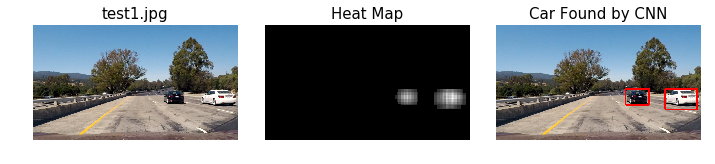

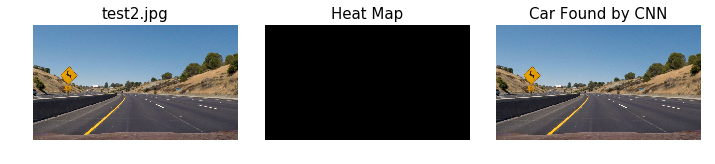

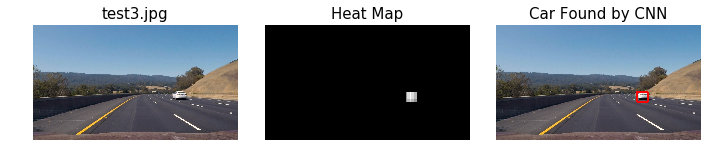

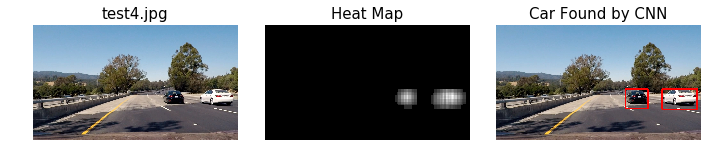

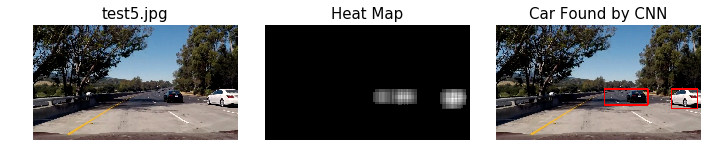

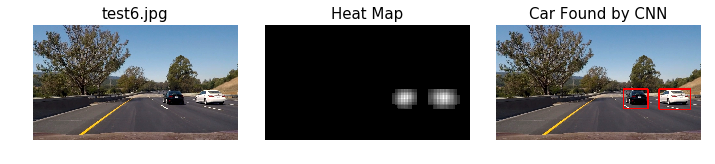

In [30]:
testfiles = sorted(glob.glob('test_images/test*.jpg'))
for fname in testfiles:
    img = mpimg.imread(fname)
    labels, heat = find_cars(img, search_by_cnn, cnn, thresh=3)
    
    img_boxed = draw_labeled_bboxes(img, labels) 
    basename = fname.split('/')[-1]
    show_images([img, heat, img_boxed],[basename, 'Heat Map', 'Car Found by CNN'], ncols=3)
    save_image("cnn_heat", basename, heat)
    save_image("cnn_found", basename, img_boxed)


## 12. Detecting Cars by YOLOv3 (Extra Works)

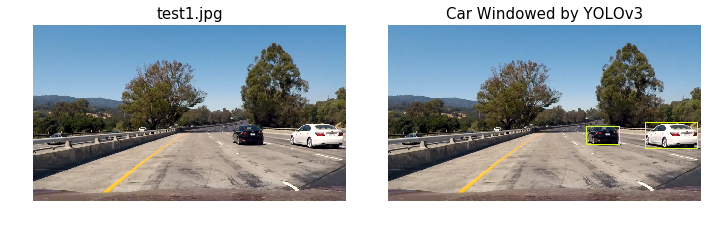

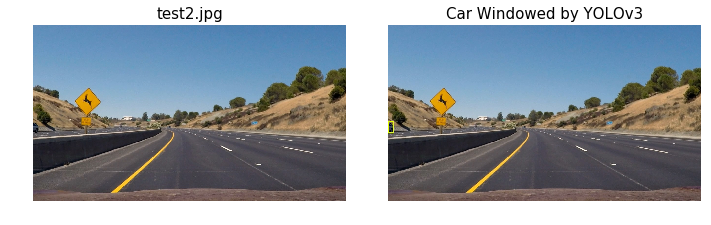

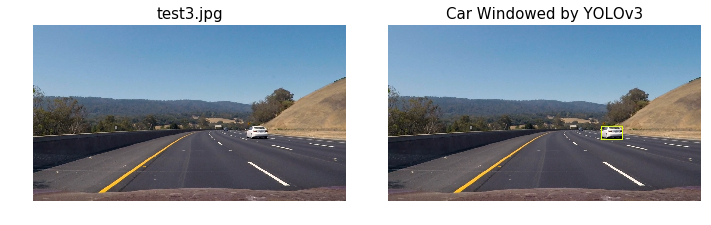

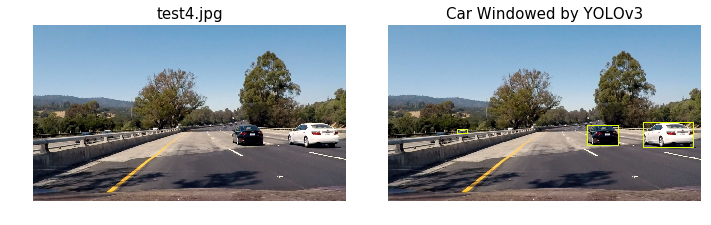

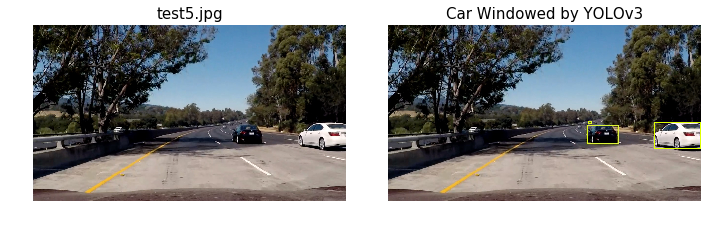

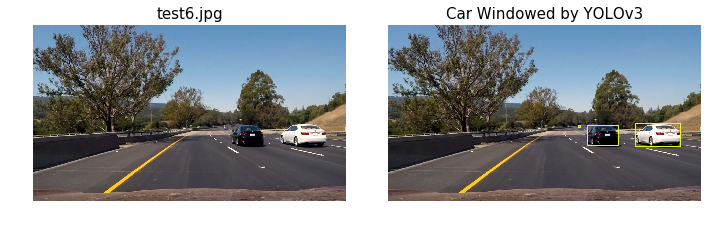

In [31]:
# the following show the results detected by YOLOv3 
# We used the pre-trained weighted but only detecting car class

for i in range(1,7):
    fname = 'test{}.jpg'.format(i)
    org = mpimg.imread('test_images/'+fname)
    yolo = mpimg.imread('yolo/'+fname)
    show_images([org, yolo],[fname, 'Car Windowed by YOLOv3'])

## 13. Video Pipelines

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image_hog(img):
    labels, _ = find_cars(img, search_by_hog, svc, thresh=5)    
    img_boxed = draw_labeled_bboxes(img, labels) 
    return img_boxed

test_output = "output_videos/test_video.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image_hog)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [01:13<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 1min 14s, sys: 500 ms, total: 1min 14s
Wall time: 1min 14s


In [34]:
test_output = "output_videos/project_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image_hog)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_output.mp4
[MoviePy] Writing video output_videos/project_output.mp4


100%|█████████▉| 1260/1261 [40:20<00:01,  1.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_output.mp4 

CPU times: user 40min 37s, sys: 18.7 s, total: 40min 55s
Wall time: 40min 20s


In [35]:
def process_image_cnn(img):
    labels, _ = find_cars(img, search_by_cnn, cnn, thresh=3)    
    img_boxed = draw_labeled_bboxes(img, labels) 
    return img_boxed

test_output = "output_videos/project_cnn.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image_cnn)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_cnn.mp4
[MoviePy] Writing video output_videos/project_cnn.mp4


100%|█████████▉| 1260/1261 [14:10<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_cnn.mp4 

CPU times: user 21min 43s, sys: 1min 50s, total: 23min 34s
Wall time: 14min 10s
